In [1]:
push!(LOAD_PATH, pwd())
using SIS,IM,PayloadGraph,PyPlot, Epidemics,JLD, TwoLevelGraphs,Dierckx
import LightGraphs

function get_c_r(N,alpha,beta)
    return 4*alpha/(beta^2*N)
end

function get_n_n(N,alpha,beta)
    return beta/alpha*N
end

function get_alpha_beta(N,c_r,n_n)
    beta = 4.0/(c_r*n_n)
    alpha = (N*beta)/n_n
    return alpha,beta
end


f(y,alpha) = alpha.*y.^2
s(y,alpha,beta) = f(y,alpha)./y - beta
#get_y_eff(y,k) = y.*(1 + (1-y)./(y.*k))
#get_s_eff(y::Array,alpha,beta,k) = alpha*get_y_eff(y,k) - beta

function plot_schematic(n_n,c_r,N,k=N-1,plot_k=false)
    beta = 4.0/(c_r*n_n)
    alpha = (N*beta)/n_n
    y_n, y_minus,y_plus,y_p,critical_determinant = get_parameters(N,alpha,beta)



    y_range = collect(0:y_p/1000:1.9*y_p)
    figure(1)
    plot(y_range,1.0./abs(N*s(y_range,alpha,beta)),"-r",label=L"$\frac{1}{N|s(y)|}$")
    if plot_k
        plot(y_range,1.0./abs(N*get_s_eff(y_range,alpha,beta,k)),"-b",label=L"$\frac{1}{N|s(y_{eff})|}$")
    end
    plot(y_range,y_range,"-k",label=L"$y$")
    axvline(y_n,linestyle="--",label=L"$y_n$")
    axvline(y_p,linestyle="-",label=L"$y_p$")
    if y_minus > 0
        axvline(y_minus,linestyle="-.",label=L"$y_1$")
        axvline(y_plus,linestyle="-.",label=L"$y_2$")
    end
    ylim([0,1.9*y_p])
    legend(prop=Dict{Any,Any}("size"=>15),loc="upper right")
    xlabel(L"$y$",size=20)
    if plot_k
        #figure(1)
        #plot(y_range,get_s_eff(y_range,alpha,beta,k),"-b",label=L"$s_{eff}(y)$")
        #plot(y_range,s(y_range),"-r",label=L"$s(y)$")
        legend(prop=Dict{Any,Any}("size"=>20),loc="upper right")
        xlabel(L"$y$",size=20)
    end
end

function plot_schematics(N,alpha,beta,k,plot_k = false)
    im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
    imk = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);

    c_r = get_c_r(N,alpha,beta)
    n_n = get_n_n(N,alpha,beta)
    pygui(true)
    close(1);close(2);close(3)
    dx = 2*n_n/N/50
    x = collect(dx:dx:2*n_n/N)
    y = IM.P_fix(im,N,x)
    yk = IM.P_fix(imk,N,x)
    figure(2,figsize=(8,5))
    plot(x,y,"-r",label=L"P_{fix}(y)")
    plot(x,yk,"-b",label=L"P_{fix}(y_{eff})")
    plot(x,x,"--k")
    xlim([0,2*n_n/N])
    y_n, y_minus, y_plus, y_p,critical_determinant = get_parameters(N,alpha,beta)
    axvline(y_n,linestyle="--",color="b",label=L"y_n")
    axvline(y_minus,linestyle="-.",color="r",label=L"y_1")
    axvline(y_plus,linestyle="-.",color="r",label=L"y_2")
    axvline(y_p,linestyle="-",color="b",label=L"y_p")
    xlabel(L"y")
    ylabel(L"P_{fix}(y)")
    legend(loc="upper left")
    title(latexstring("\$y_n = $(n_n/N), c_r = $c_r, N = $N\$"))
    #savefig("p_fix_y_n = $(n_n/N), c_r = $c_r, N = $N.png")

    figure(1,figsize=(8,5))
    plot_schematic(n_n,c_r,N,k,plot_k)
    title(latexstring("\$y_n = $(n_n/N), c_r = $c_r, N = $N\$"))

    figure(3)
    plot(x,get_s_eff(x,alpha,beta,k),"-b",label=L"$s_{eff}(y)$")
    plot(x,s(x,alpha,beta),"-r",label=L"$s(y)$")
    grid()

end

function plot_w(sizes,N,alpha,beta)

    figure(4)
    bins = logspace(log10(minimum(sizes)),log10(maximum(sizes)),150)
#     word = graph_model ? "graph" : "well-mixed"
    word = "two level"
    label = latexstring("$word, \$k = $k\$")
    PyPlot.plt[:hist](sizes,log=true,bins=bins,alpha=0.2,normed=true,label=label)

    gca()[:set_xscale]("log")

    w_range = bins[1:end]#logspace(log10(4*minimum(sizes)),log10(maximum(sizes)),30)

    P_w_th_range = normed_distribution(w_range,P_w_th(w_range,s(sqrt(w_range)./N,alpha,beta)))
    #P_w_th_range_eff = normed_distribution(w_range,P_w_th(w_range,get_s_eff(sqrt(w_range)./N,alpha,beta,k)))
    P_w_th_range_eff = normed_distribution(w_range,P_w_th(w_range,
    get_s_effective_two_level_interp(sqrt(w_range)./N,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)))
    
    correction_fac = 10
    plot(w_range,correction_fac*P_w_th_range,"-r",label=L"theory $k \to N-1$")#$P(w) \sim e^{- s(\sqrt{w})^2 w/4} w^{-3/2}/(1 + s(\sqrt{w}))$ (theory)')
    if true#graph_model
        plot(w_range,correction_fac*P_w_th_range_eff,"-g",label=latexstring("effective theory \$k = $k\$"))#$P(w) \sim e^{- s(\sqrt{w})^2 w/4} w^{-3/2}/(1 + s(\sqrt{w}))$ (theory)')
    end
        
    xlabel(L"$w$",size=20)
    ylabel(L"$P(w)$",size=20)

    legend(loc="lower left")
    ylim([1e-6,1e3])
    grid()

end

#figure out which cluster the infecteds are in from the raw data
function get_infecteds_by_clusters_vs_time(clusters::Array{Array{Int,1},1},infecteds_by_nodes_vs_time::Array{Array{Int,1},1})
    infecteds_by_clusters_vs_time::Array{Array{Int,1},1} = []
    num_clusters = length(clusters)
    for infecteds_by_nodes in infecteds_by_nodes_vs_time
        infecteds_by_clusters = zeros(Int,num_clusters)
        for (i,clust) in enumerate(clusters)
            for node in clust
                if infecteds_by_nodes[node] == 1
                    infecteds_by_clusters[i] += 1
                end
            end
        end
        push!(infecteds_by_clusters_vs_time,infecteds_by_clusters)
    end
    return infecteds_by_clusters_vs_time
    
end

#we have infecteds vs. cluster idx and want to know how many clusters of infectivity level i there are for every possible i=1:m
function get_infection_distribution_over_clusters(t::TwoLevel,infecteds_by_clusters)
    assert(t.n == length(infecteds_by_clusters))
    infection_distribution = zeros(Int,t.m+1)
    for (i,num_infected) in enumerate(infecteds_by_clusters)
        infection_distribution[num_infected+1] += 1
    end
    return infection_distribution
end

function get_two_level_with_distribution(t_template::TwoLevel,infection_distribution::Array{Int,1})
    assert(t_template.m + 1 == length(infection_distribution))
    t = TwoLevel(t_template)
    t.a = infection_distribution
    make_consistent(t)
    return t
end

function get_two_level_states(tg::TwoLevelGraph,infecteds_by_nodes_vs_time::Array{Array{Int,1},1})
    two_level_states::Array{TwoLevel,1} = []
    infecteds_by_clusters_vs_time = get_infecteds_by_clusters_vs_time(tg.clusters,infecteds_by_nodes_vs_time)
    for infecteds_by_clusters in infecteds_by_clusters_vs_time
        push!(two_level_states,get_two_level_with_distribution(tg.t,get_infection_distribution_over_clusters(tg.t,infecteds_by_clusters)))
    end
    return two_level_states
end

function get_two_level_states_from_runs(runs::Array{EpidemicRun,1})
    tg_raw = runs[1].graph_information.data
    t_raw = runs[1].graph_information.data.t
    t::TwoLevel = TwoLevel(t_raw.a,t_raw.N,t_raw.m,t_raw.n,t_raw.i,t_raw.r,t_raw.l)
    tg::TwoLevelGraph = TwoLevelGraph(tg_raw.g,t,tg_raw.clusters)
    two_level_states::Array{TwoLevel,1} = []
    for run in runs
        two_level_states = vcat(two_level_states,get_two_level_states(tg,run.infecteds_by_nodes_vs_time))
    end
    return two_level_states
end

function get_mean_distribution_from_states(two_level_states::Array{TwoLevel,1},y_desired::AbstractFloat,tol= 0.005)
    counter = 0
    t = two_level_states[1]
    accum = zeros(length(t.a))
    for t in two_level_states
        if y_desired-tolerance< t.i/t.N < y_desired+tolerance
            counter += 1
            accum += t.a
        end
    end
    accum /= counter
    println("$counter instances")
    return accum
end


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 26 days


get_mean_distribution_from_states (generic function with 2 methods)

In [2]:
data_dir_path = "../data/"  #"/mnt/D/windows/MIT/classes/6/338/project/data/"


"../data/"

In [3]:
filenames = split(readall(`ls $data_dir_path`));
filenames[end-3:end]

4-element Array{SubString{ASCIIString},1}:
 "epidemics_2016-02-18T11:42:35.jld"
 "epidemics_2016-02-24T19:36:11.jld"
 "epidemics_2016-02-24T19:37:07.jld"
 "interpolations.jld"               

In [ ]:
run(`md5 $(data_dir_path*filenames[end])`)

In [9]:
#using JLD
d = load(data_dir_path*filenames[end-1])
params = d["params"]
runs = d["runs"];
num_fixed = get_num_fixed(runs) #d["num_fixed"]
sizes = get_sizes(runs) #d["sizes"]

N = params["N"]
alpha = params["alpha"]
beta = params["beta"]
k = params["k"]
num_trials = length(runs)
graph_model = params["graph_model"]

c_r = get_c_r(N,alpha,beta)
n_n = get_n_n(N,alpha,beta)

#im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
im = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);

y_n, y_minus, y_plus, y_p,critical_determinant = get_parameters(N,alpha,beta)

#plot_schematics(N,alpha,beta,k,true)



#plot_w(sizes,N,alpha,beta)

#im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);

println(num_fixed/num_trials," ", IM.P_fix(im,N,1/N))

println("Is graph model: $graph_model")




LoadError: LoadError: stored type Epidemics.GraphInformation does not match currently loaded type
while loading In[9], in expression starting on line 2

In [35]:
two_level_states = get_two_level_states_from_runs(runs)
t = two_level_states[1]


LoadError: LoadError: type Void has no field t
while loading In[35], in expression starting on line 1

 0.7804398162272768
Is graph model: false


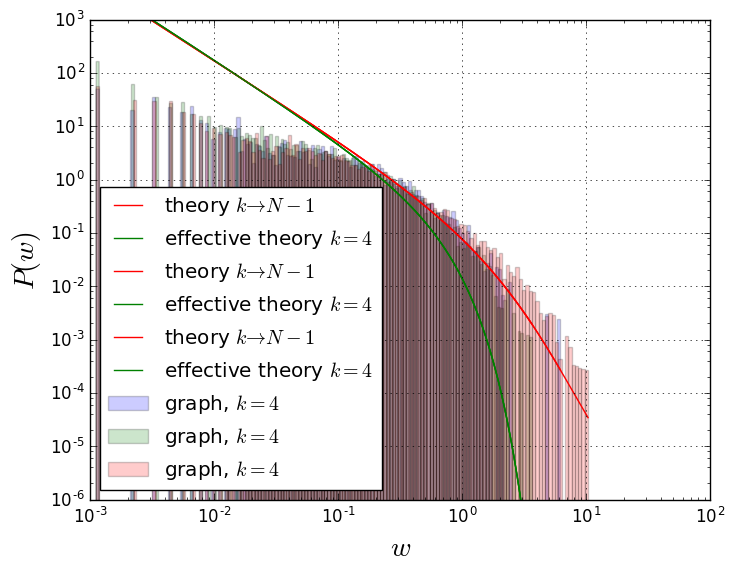

 0.7804398162272768
Is graph model: true


In [50]:
plot_w(sizes,N,alpha,beta)
plot_w(sizes_two_level,N,alpha,beta)
plot_w(sizes_well_mixed,N,alpha,beta)

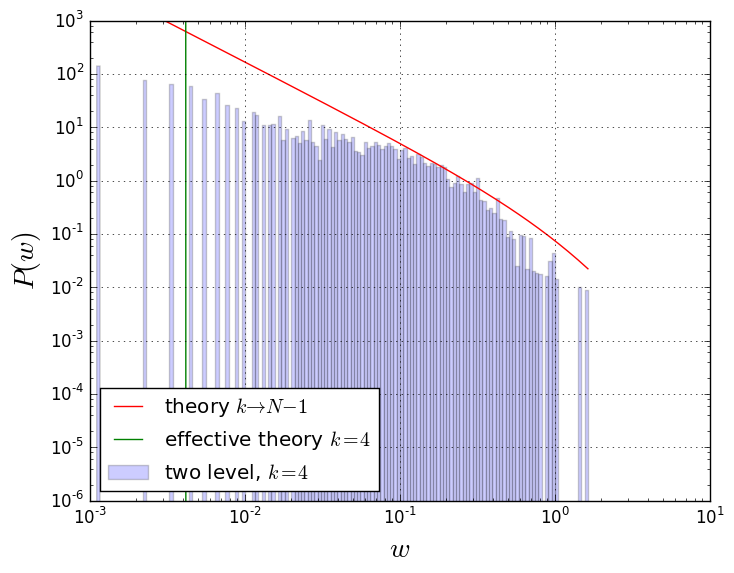

In [18]:
#plot_w(sizes_well_mixed,N,alpha,beta)
plot_w(sizes_two_level,N,alpha,beta)

In [146]:
s(x) = get_s_effective_two_level_interp(x,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)
splus(x) = get_splus_effective_two_level_interp(x,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)

s1(x) = alpha*x - beta
splus1(x) = 2 + beta + alpha*x

function P_fix(s::Function,splus::Function,N::Int,x0::Real)
    a(x) = x*s(x)
    b(x) = 1/N*x*(splus(x))
    println(a(0.001))
    
    psi(x,a,b) = exp( -2* Cubature.hquadrature(y -> a(y)/b(y),0,x)[1])
    
    return Cubature.hquadrature(y -> psi(y,a,b),0,x0)[1]/Cubature.hquadrature(y -> psi(y,a,b),0,1)[1]
end


P_fix (generic function with 1 method)

In [46]:
# a(x) = x.*s(x)
# b(x) = 1.0/N*(1-x).*x.*splus(x)

a_over_b(x) = N*s(x)./splus(x)
psi(x,a_over_b) = exp( -2* Cubature.hquadrature(y -> a_over_b(y),0,x)[1])

psi (generic function with 1 method)

In [150]:
P_fix(s,splus,N,1/N)

0.0

0.8646647167633874

07235682763610879


In [145]:
function get_s_effective_two_level(y,y_susc,y_sq_susc,y_inf,y_sq_inf,alpha::Float64,beta::Float64)
    return get_s_birth_effective_two_level(y,y_susc,y_sq_susc,alpha) - get_s_death_effective_two_level(y_inf,beta)
end

function get_splus_effective_two_level(y,y_susc,y_sq_susc,y_inf,y_sq_inf,alpha::Float64,beta::Float64)
    return get_s_birth_effective_two_level(y,y_susc,y_sq_susc,alpha) - get_s_death_effective_two_level(y_inf,beta)
end

function get_s_birth_effective_two_level(y::Array,y_susc,y_sq_susc,alpha::Float64)
    ret = (1-y)./y.*(y_susc + alpha .* y_sq_susc)
    ret[y .== 0] = 0.0
    return ret
end

function get_s_birth_effective_two_level(y::Number,y_susc,y_sq_susc,alpha::Float64)
    if y == 0 return 0.0 end
    ret = (1-y)./y.*(y_susc + alpha .* y_sq_susc)
#     ret[y .== 0] = 0
    return ret
end

function get_s_death_effective_two_level(y_inf,beta::Float64)
    return (1 - y_inf).*(1 + beta)
end
    
function get_splus_effective_two_level_interp(yy,alpha::Float64,beta::Float64,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)
    y_inf = evaluate(y_inf_interp,yy)
    y_susc = evaluate(y_susc_interp,yy)
    y_sq_inf = evaluate(y_sq_inf_interp,yy)
    y_sq_susc = evaluate(y_sq_susc_interp,yy)
    return get_splus_effective_two_level(yy,y_susc,y_sq_susc,y_inf,y_sq_inf,alpha,beta)
end


function get_s_effective_two_level_interp(yy,alpha::Float64,beta::Float64,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)
    y_inf = evaluate(y_inf_interp,yy)
    y_susc = evaluate(y_susc_interp,yy)
    y_sq_inf = evaluate(y_sq_inf_interp,yy)
    y_sq_susc = evaluate(y_sq_susc_interp,yy)
    return get_s_effective_two_level(yy,y_susc,y_sq_susc,y_inf,y_sq_inf,alpha,beta)
end


function get_s_birth_effective_two_level_interp(yy,alpha::Float64,y_susc_interp,y_sq_susc_interp)
    y_susc = evaluate(y_susc_interp,yy)
    y_sq_susc = evaluate(y_sq_susc_interp,yy)
    return get_s_birth_effective_two_level(yy,y_susc,y_sq_susc,alpha)
end

function get_s_death_effective_two_level_interp(yy,beta::Float64,y_inf_interp)
    y_inf = evaluate(y_inf_interp,yy)
    return get_s_death_effective_two_level(y_inf,beta)
end

get_s_death_effective_two_level_interp (generic function with 1 method)

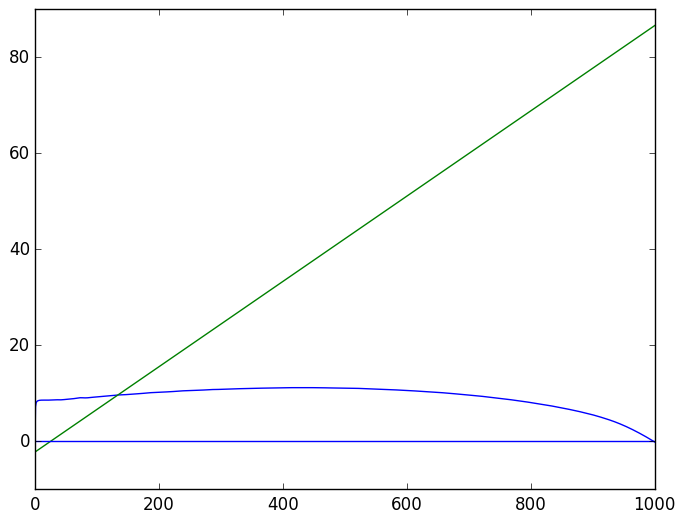

NaN

In [18]:
yy = collect(0:0.001:1)
plot(get_s_effective_two_level_interp(yy,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp))
plot(s(yy,alpha,beta))
axhline(0)
s(0,alpha,beta)

In [ ]:
w_range = collect(0.01:0.01:100)
#yy = collect(0.01:0.01:1)
w_range = logspace(-3,5,100)
y_eff = sqrt(w_range)./N
s_eff = get_s_effective_two_level_interp(y_eff,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)
s_birth_eff = get_s_birth_effective_two_level_interp(y_eff,alpha,y_susc_interp,y_sq_susc_interp)
s_death_eff = get_s_death_effective_two_level_interp(y_eff,beta,y_inf_interp)
semilogx(w_range,s_eff,"r")
semilogx(w_range,s_birth_eff,"g")
semilogx(w_range,s_death_eff,"k")
semilogx(w_range,s(y_eff,alpha,beta),"--r")
#plot(yy,y_sq_inf_interp(yy))
#y_inf_interp[sqrt(w_range)./N]

In [ ]:
tolerance = 0.005
y_desired = 0.12



accum = get_mean_distribution_from_states(two_level_states,y_desired,tolerance)
accum_stationary = get_stationary_distribution(t.N,t.m,t.l,t.r,y_desired,((x,y) -> death_fn(x,y,beta)),((x,y) -> birth_fn(x,y,alpha)))



In [ ]:
accum_stationary = get_stationary_distribution(t.N,t.m,t.l,t.r,y_desired,((x,y) -> death_fn(x,y,beta)),((x,y) -> birth_fn(x,y,alpha)))


In [ ]:
#ion()
figure()

subplot(211)
title(latexstring("\$ \\bar{y} = $(y_desired)\$"))

semilogy(accum,label="graph simulation")
semilogy(accum_stationary,label="MCMC stationary distribution")
#xlabel("# of infecteds in subgraph")
ylabel("# of subgraphs")
grid()
legend()

subplot(212)
plot(accum,label="graph simulation")
plot(accum_stationary,label="MCMC stationary distribution")
xlabel("# of infecteds in subgraph")
ylabel("# of subgraphs")
grid()
legend()
savefig("../figures/mcmc_stationary_to_graph_comparison_y_$(y_desired).png")

In [ ]:
plot_schematics(N,alpha,beta,k,true)

In [ ]:
N = 1000
n_n = 400
c_r = 0.4
alpha,beta = get_alpha_beta(N,c_r,n_n)
plot_schematics(N,alpha,beta,k,true)
im = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);
IM.P_fix(im,N,1/N)

In [38]:
im = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,N-1) , x -> 1 + beta);
IM.P_fix(im,N,0.000001)
# xx = 0:0.01:1
# plot(xx,get_s_eff(xx,alpha,beta,N-1))

1.195396263960088e-6

# why are there zero fixed for the graph case?

In [ ]:
### Well Mixed Case Two Level###
function run_epidemic_well_mixed_two_level(dt::AbstractFloat,N::Int,y_susc_fn,y_sq_susc_fn,y_inf_fn,y_sq_inf_fn,alpha::AbstractFloat,beta::AbstractFloat,fixation_threshold=1.0)
    infecteds::Array{Float64,1} = []
    n = 1
    fixed=false
    push!(infecteds,n)

    while n > 0
        if !(n < N && n < N*fixation_threshold)
            fixed = true
            break
        end
        n = update_n_two_level(dt,n,N,y_susc_fn,y_sq_susc_fn,y_inf_fn,y_sq_inf_fn,alpha,beta)
        push!(infecteds,n)
        println("$(n/N)")
    end

    size = dt*sum(infecteds)
    if fixed
        size = Inf
    end

    return EpidemicRun(infecteds,size,fixed)
end

function get_dt_two_level(alpha::AbstractFloat,beta::AbstractFloat)
    desired_rate = 0.1
    max_rate = maximum([(1 + alpha),(1 + beta)])
    dt = desired_rate/max_rate
    return float(dt)
end

function update_n_two_level(dt::AbstractFloat,n::Int,N::Int,y_susc_fn,y_sq_susc_fn,y_inf_fn,y_sq_inf_fn,alpha::AbstractFloat,beta::AbstractFloat)
    y = n/N
    y_susc = evaluate(y_susc_fn,y)
    y_inf = evaluate(y_inf_fn,y)
    y_sq_susc = evaluate(y_sq_susc_fn,y)
    y_sq_inf = evaluate(y_sq_inf_fn,y)

    prob_birth = (y_susc + y_sq_susc*alpha)*dt
    prob_death = (1 - y_inf)*(1 + beta)*dt


    if prob_birth == 0
        delta_n_plus = 0
    else
       delta_n_plus = rand(Binomial(N-n,prob_birth))
    end

    if prob_death == 0
        delta_n_minus = 0
    else
        delta_n_minus = rand(Binomial(n,prob_death))
    end

    return n + delta_n_plus - delta_n_minus

end    

In [2]:
#using Grid
interpolation_function_path = "../data/interpolations.jld"
#y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp = get_interpolations(t,alpha,beta)
#save(interpolation_function_path,"y_inf_interp",y_inf_interp,"y_sq_inf_interp",y_sq_inf_interp,"y_susc_interp",y_susc_interp,"y_sq_susc_interp",y_sq_susc_interp)
interpolation_functions = load(interpolation_function_path)
y_inf_interp = interpolation_functions["y_inf_interp"]
y_sq_inf_interp = interpolation_functions["y_sq_inf_interp"]
y_susc_interp = interpolation_functions["y_susc_interp"]
y_sq_susc_interp = interpolation_functions["y_sq_susc_interp"]



Spline1D(knots=[0.00248087,0.0174848 … 0.977497,0.992496] (99 elements), k=2, extrapolation="extrapolate", residual=0.0)

In [3]:
k = 4
#y_n = 0.1
c_r = 0.18
N = 400#100000#400
n_n = 10#10#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n
dt = get_dt_two_level(alpha,beta)
run_epidemic_fn = () -> run_epidemic_well_mixed_two_level(dt,N,y_susc_interp,y_sq_susc_interp,y_inf_interp,y_sq_inf_interp,alpha,beta,1.0)


(anonymous function)

In [76]:
run_epidemic_fn()

true


Epidemics.EpidemicRun([1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0  …  399.0,399.0,399.0,399.0,399.0,399.0,399.0,399.0,399.0,400.0],Inf,true,Array{Int64,1}[],Epidemics.GraphInformation((anonymous function),empty undirected graph,false,nothing))

In [152]:
@time runs_two_level = run_epidemics(10000,run_epidemic_fn);

 16

10000-element Array{Epidemics.EpidemicRun,1}:
 Epidemics.EpidemicRun([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  399.0,399.0,399.0,399.0,399.0,398.0,398.0,398.0,398.0,400.0],Inf,true,Array{Int64,1}[],Epidemics.GraphInformation((anonymous function),empty undirected graph,false,nothing))
 Epidemics.EpidemicRun([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  398.0,398.0,397.0,397.0,398.0,398.0,398.0,399.0,399.0,400.0],Inf,true,Array{Int64,1}[],Epidemics.GraphInformation((anonymous function),empty undirected graph,false,nothing))
 Epidemics.EpidemicRun([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  398.0,398.0,398.0,398.0,399.0,399.0,399.0,399.0,399.0,400.0],Inf,true,Array{Int64,1}[],Epidemics.GraphInformation((anonymous function),empty undirected graph,false,nothing))
 Epidemics.EpidemicRun([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  398.0,398.0,398.0,398.0,398.0,398.0,398.0,399.0,399.0,400.0],Inf,true,Array{Int64,1}[],Epidemics.GraphInformation((anonymous function),empty undirected graph,fa

.000812 seconds (48.76 M allocations: 3.757 GB, 11.84% gc time)


In [153]:
sizes_two_level = get_sizes(runs_two_level)
num_fixed_two_level = get_num_fixed(runs_two_level)
println(num_fixed_two_level/length(runs_two_level))

0.8559


In [40]:
im_effective = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,t.l + t.r) , x -> 1 + beta);
runs_well_mixed = run_epidemics1(10000, () -> run_epidemic_well_mixed(N,im_effective,1.0));



In [154]:
sizes_well_mixed = get_sizes(runs_well_mixed)
num_fixed_well_mixed = get_num_fixed(runs_well_mixed)
println(num_fixed_well_mixed/length(runs_well_mixed))

LoadError: LoadError: UndefVarError: runs_well_mixed not defined
while loading In[154], in expression starting on line 1

## todo why doesn't the process converge?

In [ ]:
using Distributions

In [20]:

function run_epidemics1(num_runs::Int,run_epidemic_fn)
    runs = EpidemicRun[]

    for i in 1:num_runs
        run = run_epidemic_fn()
        push!(runs,run)
    end
    #get rid of fixed oneus

    return runs
end


run_epidemics1 (generic function with 1 method)